In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# 1.Load data:
### Load the training and test datasets into pandas DataFrames.


# 2. Check 'SalePrice':
### Ensure that the SalePrice column is present in the training dataset, as it is the target variable for the house price prediction.


# 3. Combine datasets:
### Combine the training and test datasets into a single DataFrame for consistent preprocessing. The SalePrice column is removed from the training data before combining because it's not present in the test data.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer

# Load data
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Check if 'SalePrice' is present in the train dataset
if 'SalePrice' not in train_df.columns:
    raise KeyError("SalePrice column is missing in the training dataset.")

# Combine train and test datasets for preprocessing
combined_df = pd.concat([train_df.drop('SalePrice', axis=1), test_df], axis=0)


# Additionally, draw some plotter graphs for the features vs target variable

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


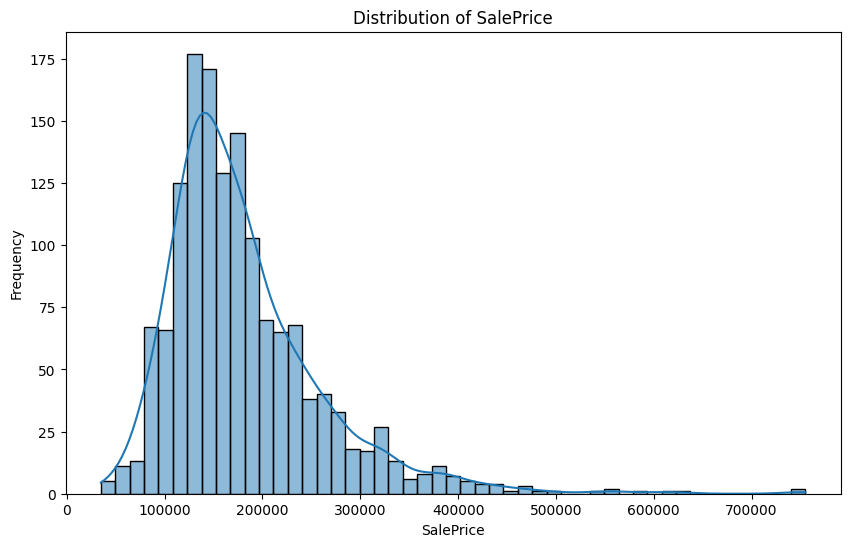

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()


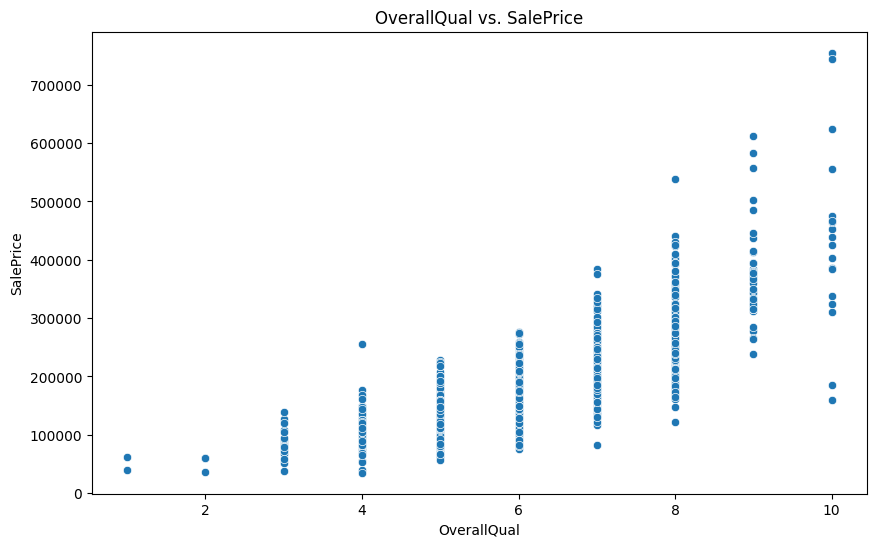

In [4]:
# Relationship of OverallQual vs. SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('OverallQual vs. SalePrice')
plt.show()


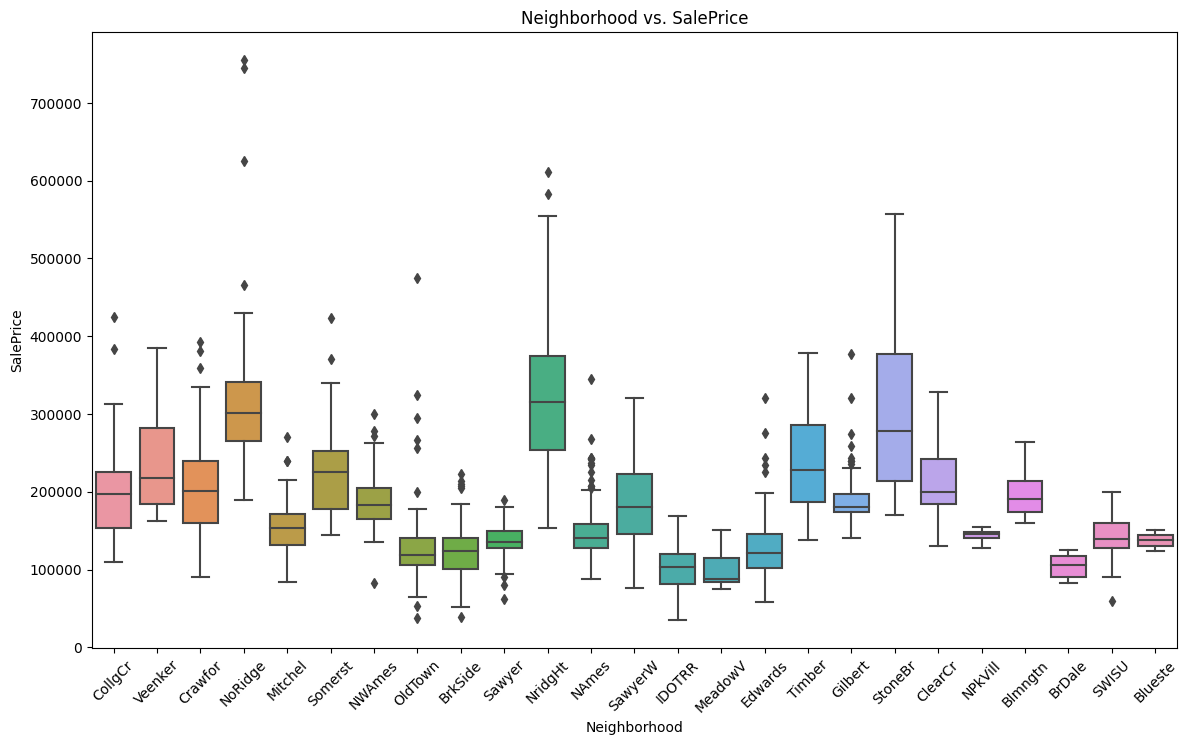

In [5]:
# Relationship of Neighborhood vs. SalePrice
plt.figure(figsize=(14, 8))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df)
plt.title('Neighborhood vs. SalePrice')
plt.xticks(rotation=45)
plt.show()


# 4. Handle missing values:
### Identify numerical columns and fill missing values with the median of each column. Using the median helps to mitigate the impact of outliers.

### Convert categorical variables to dummy/indicator variables (one-hot encoding) using pd.get_dummies. This method converts categorical data into a format that can be provided to ML algorithms to do a better job in prediction.

In [6]:
# Handle missing values (replace with median for numerical and mode for categorical)
numerical_cols = combined_df.select_dtypes(include=np.number).columns
combined_df[numerical_cols] = combined_df[numerical_cols].fillna(combined_df[numerical_cols].median())
combined_df = pd.get_dummies(combined_df, drop_first=True)


# 5. Log-transform skewed features:
### Calculate the skewness of numerical features. Skewness measures the asymmetry of the data distribution.

### Log-transform features with high skewness (greater than 0.5) to reduce skewness. This transformation can make the data more normally distributed, which helps some machine learning models perform better.

In [7]:
# Log-transform skewed numerical features
skewed_feats = combined_df[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_feats[skewed_feats > 0.5].index
for feat in high_skew:
    combined_df[feat] = np.log1p(combined_df[feat])


# 6. Split back into train and test sets:
### Separate the combined DataFrame back into training and test sets. The training set includes rows corresponding to the original training data, and the test set includes rows corresponding to the original test data.

# 7. Log-transform 'SalePrice':
### Apply a log transformation to the SalePrice column in the training set to normalize the distribution. This transformation helps to stabilize variance and reduce skewness, improving model performance.

In [8]:
# Split back into train and test sets
X_train = combined_df.iloc[:train_df.shape[0]]
X_test = combined_df.iloc[train_df.shape[0]:]

# Log-transform 'SalePrice' in the training set
y_train = np.log1p(train_df['SalePrice'])


# 8. Feature scaling:
### Use RobustScaler to scale the features. RobustScaler is less sensitive to outliers compared to StandardScaler. It removes the median and scales the data according to the Interquartile Range (IQR).

### Scale the training and test sets. Scaling ensures that all features contribute equally to the model's performance.

# 9. Shape check:
### Print the shapes of the scaled training data and target variable to ensure they match the expected dimensions.

In [9]:
# Example: Feature scaling (RobustScaler)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure everything looks correct
print(f"X_train shape: {X_train_scaled.shape}, y_train shape: {y_train.shape}")


X_train shape: (1460, 245), y_train shape: (1460,)


In [10]:
# Compute correlation matrix
#correlation_matrix = train_df.corr()

# Plot heatmap
#plt.figure(figsize=(12, 10))
#sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
#plt.title('Correlation Matrix')
#plt.show()


# ADDITONALLY, COMPUTE THE CORRELATION HEATMAP

# 10. Parameter tuning with RandomizedSearchCV:
### Define parameter distributions for RandomizedSearchCV. The ranges are chosen to explore various combinations of alpha (regularization strength), l1_ratio (balance between L1 and L2 regularization), and max_iter (maximum number of iterations).

### Initialize the ElasticNet regressor. ElasticNet combines L1 (Lasso) and L2 (Ridge) regularization, helping to handle multicollinearity and feature selection.

### Use RandomizedSearchCV to find the best hyperparameters. It randomly samples from the parameter distributions and evaluates the model using 5-fold cross-validation with the RMSE scoring metric.

### Print the best hyperparameters and the best RMSE score. The best model is stored in best_enet.

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import numpy as np

# Define parameter distributions for RandomizedSearchCV
param_dist = {
    'alpha': np.logspace(-3, 2, 1000),  # Example range, adjust as needed
    'l1_ratio': np.linspace(0, 1, 100),
    'max_iter': [2000, 3000, 4000],  # Example range, adjust as needed
}

# Initialize ElasticNet regressor
enet = ElasticNet(random_state=42, max_iter=3000)

# Perform RandomizedSearchCV with RMSE scoring
random_search = RandomizedSearchCV(estimator=enet, param_distributions=param_dist, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Print best parameters and best RMSE score
print("Best Parameters:", random_search.best_params_)
print("Best RMSE Score:", np.sqrt(-random_search.best_score_))

# Use the best estimator from RandomizedSearchCV
best_enet = random_search.best_estimator_

# Make predictions on the test data
test_predictions = best_enet.predict(X_test_scaled)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.047e+00, tolerance: 1.891e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.318e+00, tolerance: 1.800e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best Parameters: {'max_iter': 2000, 'l1_ratio': 0.17171717171717174, 'alpha': 0.0033537101520029287}
Best RMSE Score: 0.12663784820964594


In [12]:
test_predictions

array([11.62488791, 11.9230968 , 12.10345002, ..., 12.04638283,
       11.66038593, 12.32476306])

# 11. Convert the predicted values to their original scale

### Use the test ids to prepare the submission file (preserving them here)

In [13]:
test_ids = test_df['Id']
test_predictions_actual = np.expm1(test_predictions)
test_predictions_actual

array([111846.08610038, 150706.59752202, 180492.49634765, ...,
       170480.62975167, 115887.74621596, 225203.25387506])

# 12. Stacking Regressor:

### Define base estimators for the stacking model. ElasticNet (best model from previous tuning) and XGBoost are used as base models.

### Initialize the StackingRegressor with base estimators and RandomForestRegressor as the final estimator.

# 13. Parameter tuning for stacking:

### Define a parameter grid for RandomForestRegressor (final estimator). The grid includes different values for n_estimators (number of trees), max_depth (maximum depth of the trees), and min_samples_split (minimum number of samples required to split an internal node).

### Use GridSearchCV to find the best hyperparameters for the stacking model. It evaluates the model using 5-fold cross-validation with the RMSE scoring metric.

### Print the best hyperparameters and the best RMSE score. The best model is stored in grid_search.best_estimator_.

# 14. Make predictions with the best stacking model:

### Use the best stacking model from GridSearchCV to make predictions on the scaled test data.

In [14]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define base estimators for stacking
estimators = [
    ('enet', best_enet),  # Best ElasticNet model from previous tuning
    ('xgb', XGBRegressor(random_state=42))  # XGBoost model
]

# Initialize stacking regressor
stacked_reg = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=42))

# Define parameter grid for final RandomForestRegressor in stacking
param_grid = {
    'final_estimator__n_estimators': [50, 100, 200],
    'final_estimator__max_depth': [5, 10, 15],
    'final_estimator__min_samples_split': [2, 5, 10]
}

# Perform grid search over the stacking regressor
grid_search = GridSearchCV(estimator=stacked_reg, param_grid=param_grid, scoring='neg_mean_squared_error',
                           cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and best RMSE score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE Score:", np.sqrt(-grid_search.best_score_))

# Make predictions on the test data using the best model
test_predictions = grid_search.best_estimator_.predict(X_test_scaled)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'final_estimator__max_depth': 5, 'final_estimator__min_samples_split': 2, 'final_estimator__n_estimators': 100}
Best RMSE Score: 0.12366521795708896


# 15. Prepare final test predictions:

### Extract the test IDs from the original test DataFrame.

### Apply the inverse log transformation (np.expm1) to the test predictions to convert them back to the original scale of house prices.

### The final array of predictions (test_predictions_actual) represents the predicted house prices for the test set.

In [15]:
test_predictions_actual = np.expm1(test_predictions)
test_predictions_actual

# Prepare submission file
submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': test_predictions_actual})
submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.
